In [1]:
import yfinance as yf 
import pandas as pd

In [2]:
symbol = 'GOOGL'
startDate = '2010-01-01'
endDate = '2025-01-01'

data = yf.download(symbol, start=startDate, end=endDate)

print(data.head())
print(data.tail())

/var/folders/sm/37rdj_9110ng5jrk8xv0gwmc0000gn/T/ipykernel_68259/4147193050.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=startDate, end=endDate)
[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker          GOOGL      GOOGL      GOOGL      GOOGL      GOOGL
Date                                                             
2010-01-04  15.590931  15.659589  15.528494  15.595906   78169752
2010-01-05  15.522272  15.618045  15.461327  15.601626  120067812
2010-01-06  15.130977  15.568791  15.083713  15.568791  158988852
2010-01-07  14.778733  15.174260  14.742664  15.159334  256315428
2010-01-08  14.975752  15.006348  14.654604  14.726495  188783028
Price            Close        High         Low        Open    Volume
Ticker           GOOGL       GOOGL       GOOGL       GOOGL     GOOGL
Date                                                                
2024-12-24  195.647552  195.647552  193.323045  194.380543  10403300
2024-12-26  195.138763  196.286046  193.921639  194.689812  12046600
2024-12-27  192.305450  194.859427  190.200425  194.490289  18891400
2024-12-30  190.789032  192.095940  188.674021  189.352425

In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

close = data['Close'].values
close = close.reshape(-1,1)


In [4]:
scaler = MinMaxScaler(feature_range = (0,1))
scaledData = scaler.fit_transform(close)

In [5]:
traningLen = int(len(scaledData)*0.8)
trainData = scaledData[0:traningLen, :]

In [6]:
X_train = []
y_train = []

time = 60

for i in range(time, len(trainData)):
    X_train.append(trainData[i-time:i, 0])
    y_train.append(trainData[i, 0])

In [7]:
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [8]:

test_data = scaledData[traningLen - time:, :]

X_test = []
y_test = close[traningLen:, :] 

for i in range(time, len(test_data)):
    X_test.append(test_data[i-time:i, 0])


X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [9]:

print("X_train şekli: ", X_train.shape)
print("y_train şekli: ", y_train.shape)
print("X_test şekli: ", X_test.shape)
print("y_test şekli: ", y_test.shape)

X_train şekli:  (2959, 60, 1)
y_train şekli:  (2959,)
X_test şekli:  (755, 60, 1)
y_test şekli:  (755, 1)


In [10]:
import torch
import torch.nn as nn 
import torch.optim as optim

In [11]:
class LSTMModel(nn.Module):
    def __init__(self,input_size=1, hidden_layer_size=50, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        
    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions
            

In [12]:
model = LSTMModel()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print(model)

LSTMModel(
  (lstm): LSTM(1, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)


In [13]:
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float().view(-1, 1)

In [14]:
epochs = 200

for i in range(epochs):

    y_pred = model(X_train_tensor)
    
    loss = loss_function(y_pred, y_train_tensor)
    
   
    optimizer.zero_grad()
    loss.backward()     
    optimizer.step()      
    
    if (i+1) % 10 == 0:
        print(f'Epoch: {i+1}, loss: {loss.item():10.8f}')

print("\nEğitim tamamlandı!")

Epoch: 10, loss: 0.02774934
Epoch: 20, loss: 0.02551987
Epoch: 30, loss: 0.02105143
Epoch: 40, loss: 0.01599711
Epoch: 50, loss: 0.00386687
Epoch: 60, loss: 0.00149386
Epoch: 70, loss: 0.00082485
Epoch: 80, loss: 0.00035792
Epoch: 90, loss: 0.00022663
Epoch: 100, loss: 0.00018028
Epoch: 110, loss: 0.00014987
Epoch: 120, loss: 0.00013522
Epoch: 130, loss: 0.00012808
Epoch: 140, loss: 0.00012264
Epoch: 150, loss: 0.00011799
Epoch: 160, loss: 0.00011403
Epoch: 170, loss: 0.00011049
Epoch: 180, loss: 0.00010725
Epoch: 190, loss: 0.00010428
Epoch: 200, loss: 0.00010156

Eğitim tamamlandı!


In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [16]:
model.eval()

LSTMModel(
  (lstm): LSTM(1, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [17]:
X_test_tensor = torch.from_numpy(X_test).float()
with torch.no_grad():
    test_predictions_scaled = model(X_test_tensor)

In [18]:
test_predictions = scaler.inverse_transform(test_predictions_scaled.numpy())

In [19]:
rmse = np.sqrt(mean_squared_error(y_test, test_predictions))


Kök Ortalama Karesel Hata (RMSE): 8.08


/var/folders/sm/37rdj_9110ng5jrk8xv0gwmc0000gn/T/ipykernel_68259/2735256052.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_plot['Predictions'] = test_predictions


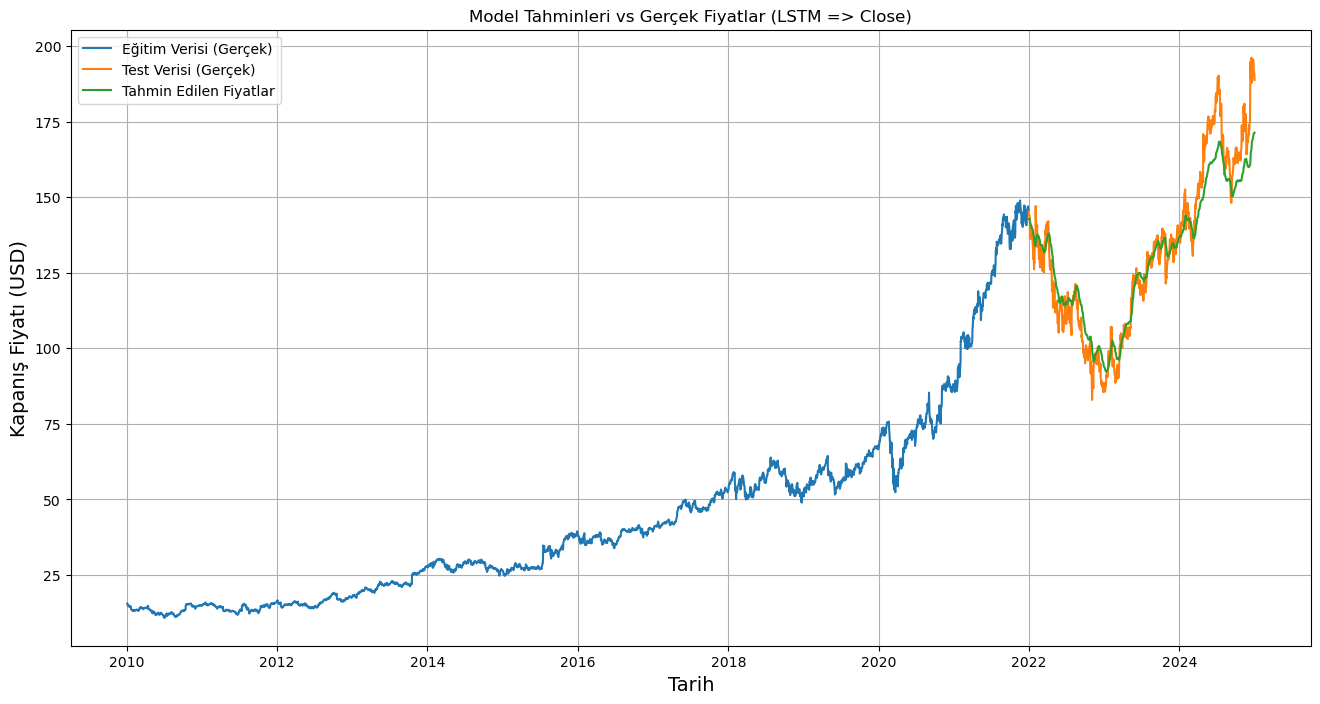

In [20]:
plot_data = data[['Close']].copy()
train_plot = plot_data.iloc[:traningLen]
valid_plot = plot_data.iloc[traningLen:]
valid_plot['Predictions'] = test_predictions
print(f"Kök Ortalama Karesel Hata (RMSE): {rmse:.2f}")
plt.figure(figsize=(16, 8))
plt.title('Model Tahminleri vs Gerçek Fiyatlar (LSTM => Close)')
plt.xlabel('Tarih', fontsize=14)
plt.ylabel('Kapanış Fiyatı (USD)', fontsize=14)
plt.plot(train_plot['Close'], label='Eğitim Verisi (Gerçek)')
plt.plot(valid_plot['Close'], label='Test Verisi (Gerçek)')
plt.plot(valid_plot['Predictions'], label='Tahmin Edilen Fiyatlar')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [21]:

class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.gru = nn.GRU(input_size, hidden_layer_size, batch_first=True)

        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        gru_out, _ = self.gru(input_seq)
        
        predictions = self.linear(gru_out[:, -1, :])
        return predictions

In [22]:
model = GRUModel()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float().view(-1, 1)
epochs = 200

for i in range(epochs):
    y_pred = model(X_train_tensor)
    
    loss = loss_function(y_pred, y_train_tensor)
    
    optimizer.zero_grad() 
    loss.backward()    
    optimizer.step()     
    
    if (i+1) % 10 == 0:
        print(f'Epoch: {i+1}, loss: {loss.item():10.8f}')

print("\nEğitim tamamlandı!")

Epoch: 10, loss: 0.02057139
Epoch: 20, loss: 0.01453940
Epoch: 30, loss: 0.00920338
Epoch: 40, loss: 0.00302429
Epoch: 50, loss: 0.00046323
Epoch: 60, loss: 0.00008453
Epoch: 70, loss: 0.00019211
Epoch: 80, loss: 0.00004737
Epoch: 90, loss: 0.00005765
Epoch: 100, loss: 0.00004514
Epoch: 110, loss: 0.00004088
Epoch: 120, loss: 0.00004070
Epoch: 130, loss: 0.00003948
Epoch: 140, loss: 0.00003890
Epoch: 150, loss: 0.00003849
Epoch: 160, loss: 0.00003807
Epoch: 170, loss: 0.00003768
Epoch: 180, loss: 0.00003734
Epoch: 190, loss: 0.00003701
Epoch: 200, loss: 0.00003671

Eğitim tamamlandı!


In [23]:
X_test_tensor = torch.from_numpy(X_test).float()
with torch.no_grad():
    test_predictions_scaled = model(X_test_tensor)
test_predictions = scaler.inverse_transform(test_predictions_scaled.numpy())
rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

Kök Ortalama Karesel Hata (RMSE): 3.57


/var/folders/sm/37rdj_9110ng5jrk8xv0gwmc0000gn/T/ipykernel_68259/2394416135.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_plot['Predictions'] = test_predictions


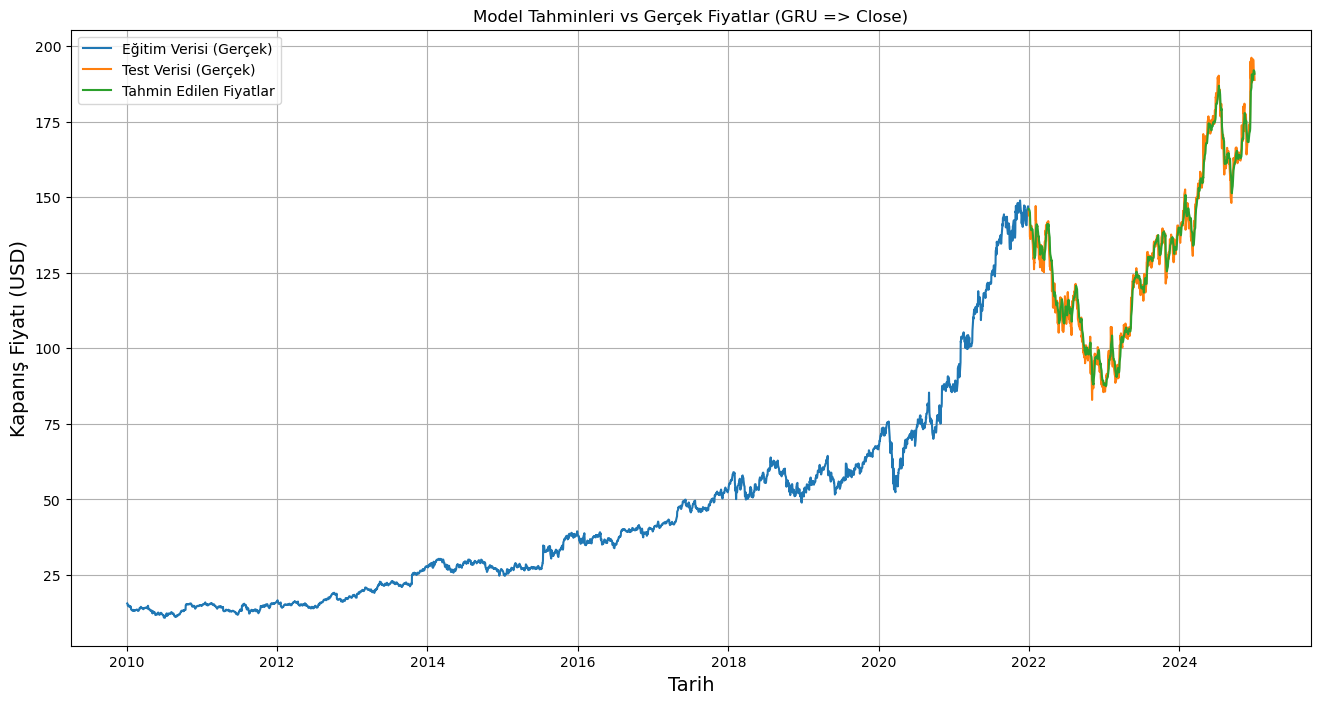

In [24]:
plot_data = data[['Close']].copy()
train_plot = plot_data.iloc[:traningLen]
valid_plot = plot_data.iloc[traningLen:]
valid_plot['Predictions'] = test_predictions

print(f"Kök Ortalama Karesel Hata (RMSE): {rmse:.2f}")

plt.figure(figsize=(16, 8))
plt.title('Model Tahminleri vs Gerçek Fiyatlar (GRU => Close)')
plt.xlabel('Tarih', fontsize=14)
plt.ylabel('Kapanış Fiyatı (USD)', fontsize=14)
plt.plot(train_plot['Close'], label='Eğitim Verisi (Gerçek)')
plt.plot(valid_plot['Close'], label='Test Verisi (Gerçek)')
plt.plot(valid_plot['Predictions'], label='Tahmin Edilen Fiyatlar')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [25]:
import pandas_ta as ta

In [26]:
if isinstance(data.columns, pd.MultiIndex):
  
    data.columns = data.columns.droplevel(1)

data.ta.ema(length=14, append=True) 
data.ta.rsi(length=14, append=True) 
data.dropna(inplace=True)
print(data.head())

Price           Close       High        Low       Open     Volume     EMA_14  \
Date                                                                           
2010-01-25  13.432952  13.678726  13.321259  13.596883  176619204  14.579694   
2010-01-26  13.493151  13.671759  13.340663  13.382454  174045780  14.434821   
2010-01-27  13.485190  13.623252  13.316283  13.464543  158417424  14.308204   
2010-01-28  13.290911  13.607083  13.199119  13.544645  129034836  14.172565   
2010-01-29  13.182701  13.457579  13.074989  13.395390  165454380  14.040583   

Price          RSI_14  
Date                   
2010-01-25  15.124022  
2010-01-26  17.544814  
2010-01-27  17.473842  
2010-01-28  15.794542  
2010-01-29  14.933687  


In [27]:
feature_columns = ['Close', 'Volume', 'EMA_14', 'RSI_14']
features = data[feature_columns].values

In [28]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(features)

In [29]:
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]

In [30]:
X_train = []

y_train = []


In [31]:
time_step = 60
num_features = len(feature_columns) 

In [32]:
for i in range(time_step, len(train_data)):
    
    X_train.append(train_data[i-time_step:i, :]) 
    y_train.append(train_data[i, 0])   

In [33]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], num_features))

In [34]:
test_data = scaled_data[training_data_len - time_step:, :]
X_test = []
y_test = data['Close'].values[training_data_len:]

In [35]:
for i in range(time_step, len(test_data)):
    X_test.append(test_data[i-time_step:i, :])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], num_features))

In [36]:
class LSTMModel2(nn.Module):
    def __init__(self, input_size=4, hidden_layer_size=128, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

model = LSTMModel2(input_size=num_features)

In [37]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float().view(-1, 1)
epochs = 200

for i in range(epochs):

    y_pred = model(X_train_tensor)
    
    loss = loss_function(y_pred, y_train_tensor)
    

    optimizer.zero_grad() 
    loss.backward()    
    optimizer.step()      
    
    if (i+1) % 10 == 0:
        print(f'Epoch: {i+1}, loss: {loss.item():10.8f}')

print("\nEğitim tamamlandı!")

Epoch: 10, loss: 0.02395992
Epoch: 20, loss: 0.01010655
Epoch: 30, loss: 0.00470539
Epoch: 40, loss: 0.00066674
Epoch: 50, loss: 0.00045615
Epoch: 60, loss: 0.00034714
Epoch: 70, loss: 0.00018637
Epoch: 80, loss: 0.00018125
Epoch: 90, loss: 0.00014616
Epoch: 100, loss: 0.00013144
Epoch: 110, loss: 0.00011726
Epoch: 120, loss: 0.00010485
Epoch: 130, loss: 0.00009477
Epoch: 140, loss: 0.00008601
Epoch: 150, loss: 0.00007846
Epoch: 160, loss: 0.00007206
Epoch: 170, loss: 0.00006672
Epoch: 180, loss: 0.00006235
Epoch: 190, loss: 0.00005884
Epoch: 200, loss: 0.00005607

Eğitim tamamlandı!


Kök Ortalama Karesel Hata (RMSE): 4.54


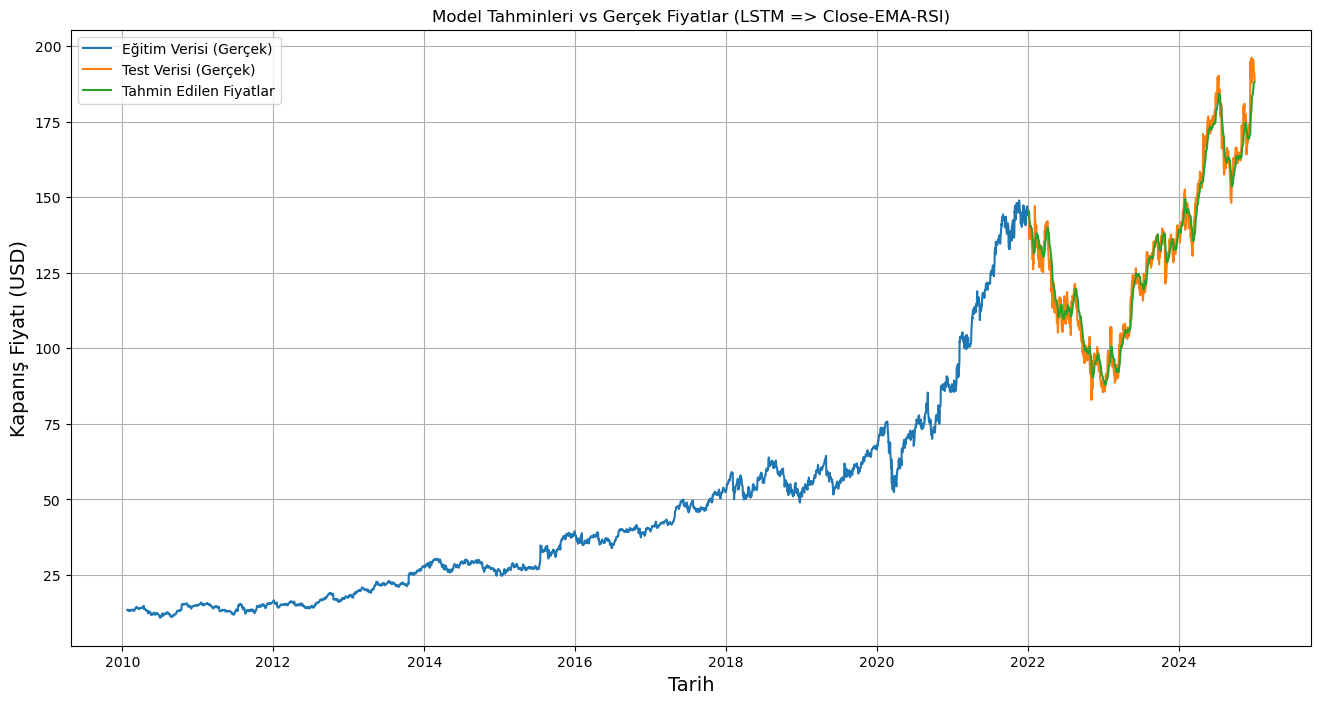

In [38]:

model.eval()

X_test_tensor = torch.from_numpy(X_test).float()

with torch.no_grad():
    test_predictions_scaled = model(X_test_tensor)

predictions_scaled_np = test_predictions_scaled.numpy()

dummy_array = np.zeros((predictions_scaled_np.shape[0], num_features))

dummy_array[:, 0] = predictions_scaled_np[:, 0]

unscaled_predictions_full = scaler.inverse_transform(dummy_array)

test_predictions = unscaled_predictions_full[:, 0]

rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print(f"Kök Ortalama Karesel Hata (RMSE): {rmse:.2f}")

valid_plot = pd.DataFrame(index=data.index[training_data_len:])
valid_plot['Close'] = y_test
valid_plot['Predictions'] = test_predictions

plt.figure(figsize=(16, 8))
plt.title('Model Tahminleri vs Gerçek Fiyatlar (LSTM => Close-EMA-RSI)')
plt.xlabel('Tarih', fontsize=14)
plt.ylabel('Kapanış Fiyatı (USD)', fontsize=14)
plt.plot(data['Close'].iloc[:training_data_len], label='Eğitim Verisi (Gerçek)') 
plt.plot(valid_plot['Close'], label='Test Verisi (Gerçek)')
plt.plot(valid_plot['Predictions'], label='Tahmin Edilen Fiyatlar')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [39]:
class GRUModel2(nn.Module):
    def __init__(self, input_size=4, hidden_layer_size=128, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.gru = nn.GRU(input_size, hidden_layer_size, batch_first=True)

        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):

        gru_out, _ = self.gru(input_seq)
        predictions = self.linear(gru_out[:, -1, :])
        return predictions
model = GRUModel2(input_size=num_features)

In [40]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float().view(-1, 1)
epochs = 200

for i in range(epochs):
    # Forward pass
    y_pred = model(X_train_tensor)
    
    # Kaybı hesapla
    loss = loss_function(y_pred, y_train_tensor)
    
    # Geri yayılım (Backpropagation)
    optimizer.zero_grad() # Önceki adımlardan kalan gradyanları sıfırla
    loss.backward()     # Yeni gradyanları hesapla
    optimizer.step()      # Ağırlıkları güncelle
    
    if (i+1) % 10 == 0:
        print(f'Epoch: {i+1}, loss: {loss.item():10.8f}')

print("\nEğitim tamamlandı!")

Epoch: 10, loss: 0.01082626
Epoch: 20, loss: 0.00121258
Epoch: 30, loss: 0.00035124
Epoch: 40, loss: 0.00024107
Epoch: 50, loss: 0.00018148
Epoch: 60, loss: 0.00009247
Epoch: 70, loss: 0.00005580
Epoch: 80, loss: 0.00004638
Epoch: 90, loss: 0.00004272
Epoch: 100, loss: 0.00004045
Epoch: 110, loss: 0.00003884
Epoch: 120, loss: 0.00003781
Epoch: 130, loss: 0.00003700
Epoch: 140, loss: 0.00003633
Epoch: 150, loss: 0.00003572
Epoch: 160, loss: 0.00003517
Epoch: 170, loss: 0.00003468
Epoch: 180, loss: 0.00003422
Epoch: 190, loss: 0.00003380
Epoch: 200, loss: 0.00003342

Eğitim tamamlandı!


Kök Ortalama Karesel Hata (RMSE): 3.62


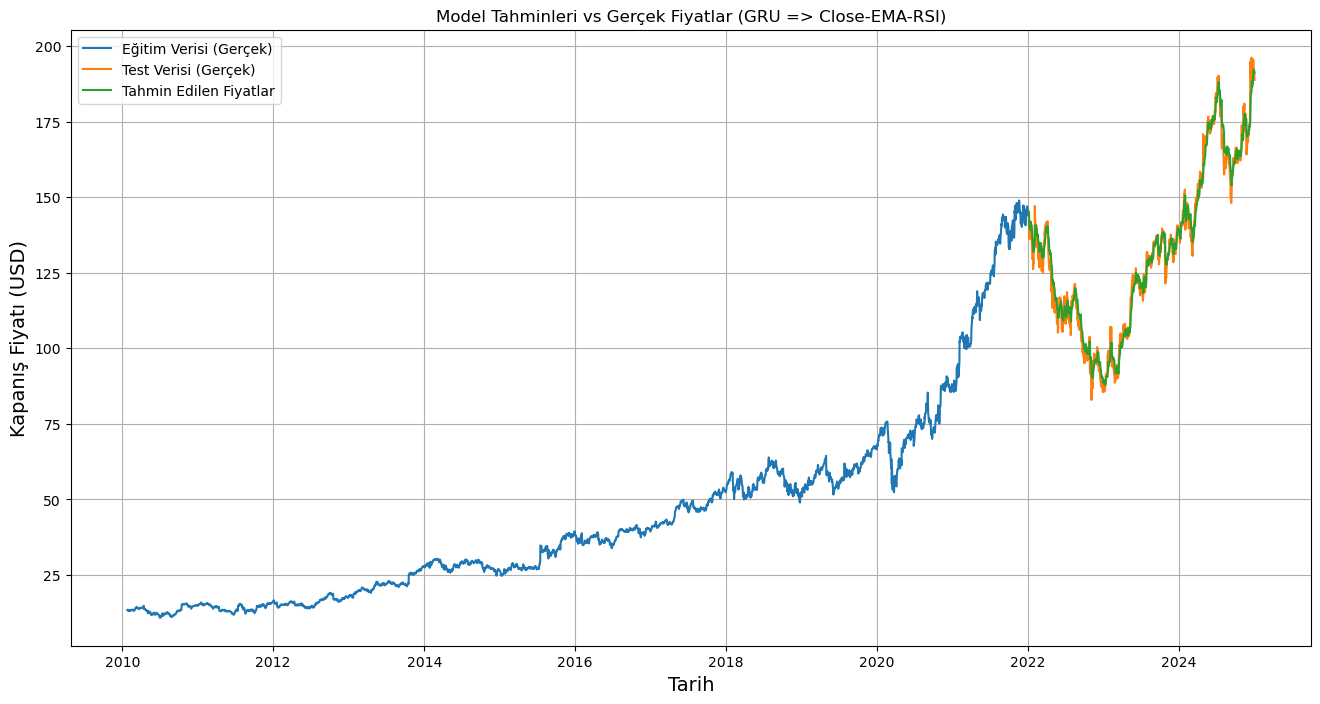

In [41]:
# 1. Modeli değerlendirme moduna alalım
model.eval()

X_test_tensor = torch.from_numpy(X_test).float()

# 2. Test verisi üzerinde tahmin yapalım
with torch.no_grad():
    test_predictions_scaled = model(X_test_tensor)

predictions_scaled_np = test_predictions_scaled.numpy()

# !!!--------- HATA DÜZELTME ADIMI BAŞLANGIÇ ---------!!!

# 3. Scaler'ın beklediği şekle sahip boş bir dizi oluşturalım
dummy_array = np.zeros((predictions_scaled_np.shape[0], num_features))

# 4. Boş dizinin ilk sütununa kendi tahminlerimizi yerleştirelim
dummy_array[:, 0] = predictions_scaled_np[:, 0]

# 5. Şimdi bu tam şekilli dizinin ölçeğini geri alalım
unscaled_predictions_full = scaler.inverse_transform(dummy_array)

# 6. Sadece işimize yarayan ilk sütunu (gerçek fiyat tahminlerini) alalım
test_predictions = unscaled_predictions_full[:, 0]



# 7. RMSE değerini hesaplayalım (y_test'in şeklini de uyumlu hale getirelim)
rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print(f"Kök Ortalama Karesel Hata (RMSE): {rmse:.2f}")

# 8. Sonuçları Görselleştirelim
# Görselleştirme kodunda bir hata olmaması için y_test'i de içeren bir DataFrame oluşturalım
valid_plot = pd.DataFrame(index=data.index[training_data_len:])
valid_plot['Close'] = y_test
valid_plot['Predictions'] = test_predictions

plt.figure(figsize=(16, 8))
plt.title('Model Tahminleri vs Gerçek Fiyatlar (GRU => Close-EMA-RSI)')
plt.xlabel('Tarih', fontsize=14)
plt.ylabel('Kapanış Fiyatı (USD)', fontsize=14)
plt.plot(data['Close'].iloc[:training_data_len], label='Eğitim Verisi (Gerçek)') # Eğitim verisi için de data'dan alalım
plt.plot(valid_plot['Close'], label='Test Verisi (Gerçek)')
plt.plot(valid_plot['Predictions'], label='Tahmin Edilen Fiyatlar')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()